In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from scripts import make_grid as mg

In [3]:
from scripts import poisson_covariance as pc

In [4]:
data = pd.read_pickle('work_catalog_pd')

In [ ]:
time_split = mg.TXYSplit(data, 10.0, 2, 2)
xyt_matrix = mg.TXYMatrix(time_split, 2, 2)
t = int(xyt_matrix.shape[2] * 0.05)
xyt_matrix_train, xyt_matrix_test = (xyt_matrix[:,:,:t]).copy(), (xyt_matrix[:,:,t:]).copy()

In [135]:
anomaly_flag = mg.target_anomaly_matrix(xyt_matrix_test, 7.0)
anomaly_x, anomaly_y, anomaly_t = np.where(anomaly_flag != 0)
anomaly_coord = zip(anomaly_x, anomaly_y, anomaly_t)

In [160]:
T = 1000
t_matrix_train = xyt_matrix_train[6, 10,:]
t_matrix_test = xyt_matrix_test[6, 10,:]
result = pc.MakeDictStatistics(T, t_matrix_train, t_matrix_test)

Подготовим матрицу фичей $X$. Переведем ее из словаря и добавим несколько фичей.

In [161]:
X = pd.DataFrame.from_dict(result)

In [162]:
X.shape

(907, 12)

In [139]:
[i for i in X.columns]

['KLFutrePastBeta',
 'KLPastFutureBeta',
 'LogOdssBeta',
 'beta_mu_max',
 'beta_mu_med',
 'beta_mu_min',
 'diff',
 'lambda_mu',
 'lambda_sigma',
 'mean_pr_y',
 'mode_pr_y',
 'p_value_beta']

Разобьем на трейн и тест в зависимости от распределения числа аномально сильных землетрясений во времени:

In [140]:
def AnomalyTimeInCell(x, y, max_time, max_m):
    t = np.array([False if xyt_matrix_test[x, y, i] is None\
                  else xyt_matrix_test[x, y, i]['magnitude'].max() >= max_m for i in range(max_time)])
    return np.where(t == True), t

In [142]:
AnomalyTimeInCell(6, 10, 907, 5.5)

((array([  8,  13,  19, 122, 126, 239, 348, 364, 412, 443, 452, 453, 458,
         460, 461, 466, 471, 474, 493, 494, 495, 497, 499, 524, 588, 862]),),
 array([False, False, False, False, False, False, False, False,  True,
        False, False, False, False,  True, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, Fal

In [163]:
X_train = pd.DataFrame(X.values[:500, :].copy())
X_test = pd.DataFrame(X.values[500:, :].copy())

In [164]:
X.shape

(907, 12)

In [145]:
y = np.array([False] * X.shape[0])
y[AnomalyTimeInCell(6, 10, 907, 5.5)[0]] = True
y_train = y[:500]
y_test = y[500:]

Возьмем аномалии до $100$ в трейн, остальные в тест. Бинаризуем матрицу. Для этого посчитаем 2.5% и 97.5% квантили по X_train. Все, что в не их назовем аномалиями и отметим $1$, остальное $0$.

In [146]:
for i in X_train.columns:
    min_q = np.sort(X_train[i])[int(X_train[i].shape[0] * 0.01)]
    max_q = np.sort(X_train[i])[int(X_train[i].shape[0] * 0.99)]
 
    X_train.loc[(X_train[i] >= max_q) | (X_train[i] <= min_q), i] = True
    X_train.loc[(X_train[i] < max_q) & (X_train[i] > min_q), i] = False
    
    X_test.loc[(X_test[i] >= max_q) | (X_test[i] <= min_q), i] = True
    X_test.loc[(X_test[i] < max_q) & (X_test[i] > min_q), i] = False

In [147]:
import sklearn as sk
from joblib import Parallel, delayed
parallel_ = Parallel(n_jobs=-1, verbose=0)
from predictiveSelector import predictiveSelector as ps

Установим параметры, при которых мы считаем предупреждение о землетрясении успешным:
+ horizon: 1, т.е за 48 дней (или одну ячейку) от землетрясения
+ window: 1, т.е. 48 дней
+ insense: 0

In [152]:
horizon, window, insens = 0, 20, 0

In [153]:
selector = ps.predictiveSelector(10, ps.reducer_all_true, window=window, pre=horizon, post=insens, verbose=1)

Установим способы отбора фичей:

In [155]:
X_train.shape

(5000, 12)

In [156]:
X.shape

(907, 12)

In [154]:
selection_strategy = {'mode':["ttest", "soft"], 'alpha':0.05, 'soft_threshold':5.0}

In [165]:
selector_ = sk.clone(selector).fit(X_train, pd.DataFrame(y_train), batch=(100, 100), instance=parallel_)

In [166]:
selector_.score_#.loc[0]

<class 'pandas.core.panel.Panel'>
Dimensions: 1 (items) x 4082 (major_axis) x 7 (minor_axis)
Items axis: 0 to 0
Major_axis axis: (0,) to (11,)
Minor_axis axis: NEG_SUM to SIGNALS

In [167]:
predictive_X = selector_.transform(X_test, **selection_strategy)
selected_features_ = {key_: df_.columns.tolist() for key_, df_ in predictive_X.iteritems()}

In [168]:
df_ = selector_.metrics_.loc[0]

In [169]:
df_.loc[df_.PV < 0.5]

,POS_RATIO,NEG_RATIO,FA/CF,PV


In [170]:
df_.loc[df_["FA/CF"] < 5]

,POS_RATIO,NEG_RATIO,FA/CF,PV


In [112]:
selector_.score_.loc[0, df_.PV < 0.5]

,NEG_SUM,NEG_OR,NEG_TOT,POS_SUM,POS_OR,POS_TOT,SIGNALS
"(0, 1, 2, 3, 4, 5, 6, 7, 8)",55,8,15,23,10,15,15
"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",55,8,15,23,10,15,15
"(0, 1, 2, 3, 4, 5, 6, 7, 8, 10)",55,8,15,23,10,15,15
"(0, 1, 2, 3, 4, 5, 6, 7, 8, 11)",55,8,15,23,10,15,15
"(0, 1, 2, 3, 4, 5, 6, 8)",55,8,15,23,10,15,15
"(0, 1, 2, 3, 4, 5, 6, 8, 9)",55,8,15,23,10,15,15
"(0, 1, 2, 3, 4, 5, 6, 8, 9, 10)",55,8,15,23,10,15,15
"(0, 1, 2, 3, 4, 5, 6, 8, 9, 11)",55,8,15,23,10,15,15
"(0, 1, 2, 3, 4, 5, 6, 8, 10)",55,8,15,23,10,15,15
"(0, 1, 2, 3, 4, 5, 6, 8, 10, 11)",55,8,15,23,10,15,15


In [28]:
# (8,)	0.25	0.000000	0.000000	0.0

In [113]:
selected_features_

{}

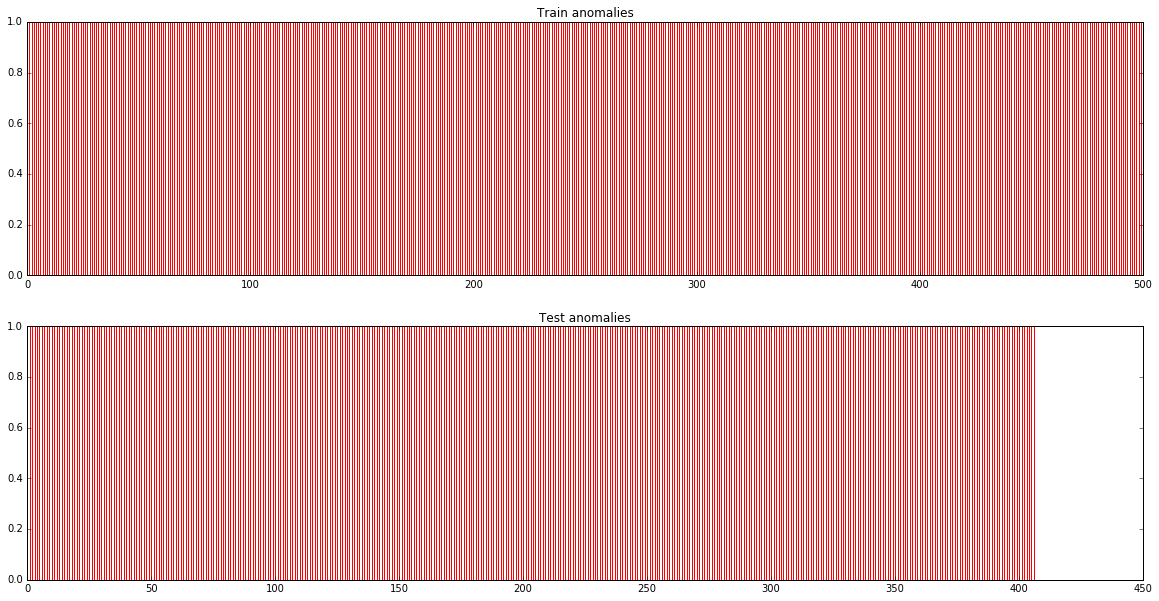

In [171]:
fig = plt.figure(figsize=(20, 10))
ax_train = fig.add_subplot(211)
#ax_train.set_xticks(np.linspace(0, y_train.shape[0]-1, y_train.shape[0]))
plt.title('Train anomalies')


ax_test = fig.add_subplot(212)
#ax_test.set_xticks(np.linspace(0, y_test.shape[0]-1, y_test.shape[0]))
plt.title('Test anomalies')


earthquake_big_time = np.where(y_train == 1)[0]
[ax_train.axvline(i, c='k') for i in earthquake_big_time];
for j in range(X_train.shape[1]):
    time_anomaly = np.where(X_train[X_train.columns[j]] > 0)
    [ax_train.axvline(i, c='r') for j, i in enumerate(time_anomaly[0])];

    
earthquake_big_time = np.where(y_test == 1)[0]
[ax_test.axvline(i, c='k') for i in earthquake_big_time];
for j in range(X_test.shape[1]):
    time_anomaly = np.where(X_test[X_test.columns[j]] > 0)
    [ax_test.axvline(i, c='r') for i in time_anomaly[0]];


In [ ]:
fig = plt.figure(figsize=(20, 10))
ax_train = fig.add_subplot(211)
ax_train.set_xticks(np.linspace(0, y_train.shape[0]-1, y_train.shape[0]))
plt.title('Train anomalies')


ax_test = fig.add_subplot(212)
ax_test.set_xticks(np.linspace(0, y_test.shape[0]-1, y_test.shape[0]))
plt.title('Test anomalies')


earthquake_big_time = np.where(y_train == 1)[0]
[ax_train.axvline(i, c='k') for i in earthquake_big_time];
for j in range(X_train.shape[1]):
    time_anomaly = np.where(X_train[X_train.columns[8]] > 0)
    [ax_train.axvline(i, c='r') for j, i in enumerate(time_anomaly[0])];

    
earthquake_big_time = np.where(y_test == 1)[0]
[ax_test.axvline(i, c='k') for i in earthquake_big_time];
for j in range(X_test.shape[1]):
    time_anomaly = np.where(X_test[X_test.columns[8]] > 0)
    [ax_test.axvline(i, c='r') for i in time_anomaly[0]];
